In [64]:
%matplotlib inline

In [65]:
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Plot results from across multiple sweeps
The below code is used for grouping runs from across multiple sweeps based on a condition and averaging their values for the specified y variable within each grouping of the condition. The standard use case is when several sweeps have been done using different ranges of values for a given hyperparameter and we want to compare the learning curves for all hyperparameter values. Typically within each sweep there will be multiple runs (with different random seeds) for each hyperparameter value, and each learning curve will display values averaged over these runs. Note that this code can also be used to compare values of the condition from a single sweep if only one sweep id is provided, or to compare individual runs if the condition is set to run_id. 

#### Edit the cell below with desired values for plotting

In [66]:
SWEEP_IDS = ['4gm5nbom', 'ovos9ur2', 'yriz8rpz']
CONDITION = 'algorithm'
X = 'episode'
Y = 'episode_len'
X_LIM = (0, 150)
Y_LIM = (0, 1200)
ERROR_BAR = 'se'
SMOOTH = 10

In [67]:
def config_to_algorithm(run_config):
    '''
    Get algorithm name from a run config
    '''
    if run_config['agent'] == 'gentest':
        generator = run_config['agent_args']['generator']
        if generator == "grid_subgoal":
            if run_config['agent_args']['replace_ratio'] == 0:
                return 'random-tasks'
            return 'gen-and-test'
        elif generator == "fourrooms_corner":
            return 'corner'
        elif generator == "fourrooms_hallway":
            return 'hallway'
    return run_config['agent']

In [68]:
def get_datasets(sweep_ids, condition, x, y):
    '''
    Returns data for all runs assosiated with given sweep ids
    '''
    # Iterate over sweeps
    run_dfs = []
    for sweep_id in sweep_ids:
        sweep_dir = f'../sweep_data/{sweep_id}'
        config_dir = os.path.join(sweep_dir, 'config')
        data_dir = os.path.join(sweep_dir, 'data')
        # Iterate over run configs for the sweep
        for filename in os.listdir(config_dir):
            # Load run config and determine value of condition
            config_path = os.path.join(config_dir, filename)
            with open(config_path, 'r') as file:
                run_config = json.load(file)
            if condition == 'algorithm':
                run_val = config_to_algorithm(run_config)
            else:
                run_val = run_config.get(condition, run_config['agent_args'].get(condition))
            # Load run data
            data_path = os.path.join(data_dir, f'{run_config["run_id"]}.csv')
            run_df = pd.read_csv(data_path, usecols=[x, y])
            # make new column for the condition value
            run_df[condition] = run_val
            run_df.dropna(inplace=True)
            run_dfs.append(run_df)
    return run_dfs

In [69]:
def make_plot(sweep_ids, condition, x, y, x_lim, y_lim, smooth, errorbar='ci'):
    '''
    Plots
    '''
    run_dfs = get_datasets(sweep_ids, condition, x, y)
    # Compute running average of y values for each run 
    if smooth > 1:
        for df in run_dfs:
            df[y] = df[y].rolling(window=smooth, min_periods=1, center=True).mean()
    stacked_df = pd.concat(run_dfs, axis=0, ignore_index=True)
    # Plot learning curves for each level of the condition, averaging y values for each timestep across runs with the same level
    sns.set_theme(style="darkgrid", font_scale=1.5, rc={"figure.dpi":300, 'savefig.dpi':300})
    sns.lineplot(x=x, y=y, hue=condition, data=stacked_df, errorbar=errorbar)
    plt.xlim(*x_lim)
    plt.ylim(*y_lim)
    plt.legend(loc='best').set_draggable(True)
    # Set x-axis scale in scientific notation if max x is large
    xscale = np.max(np.asarray(stacked_df[x])) > 5e3
    if xscale:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout(pad=0.5)
    plt.show()

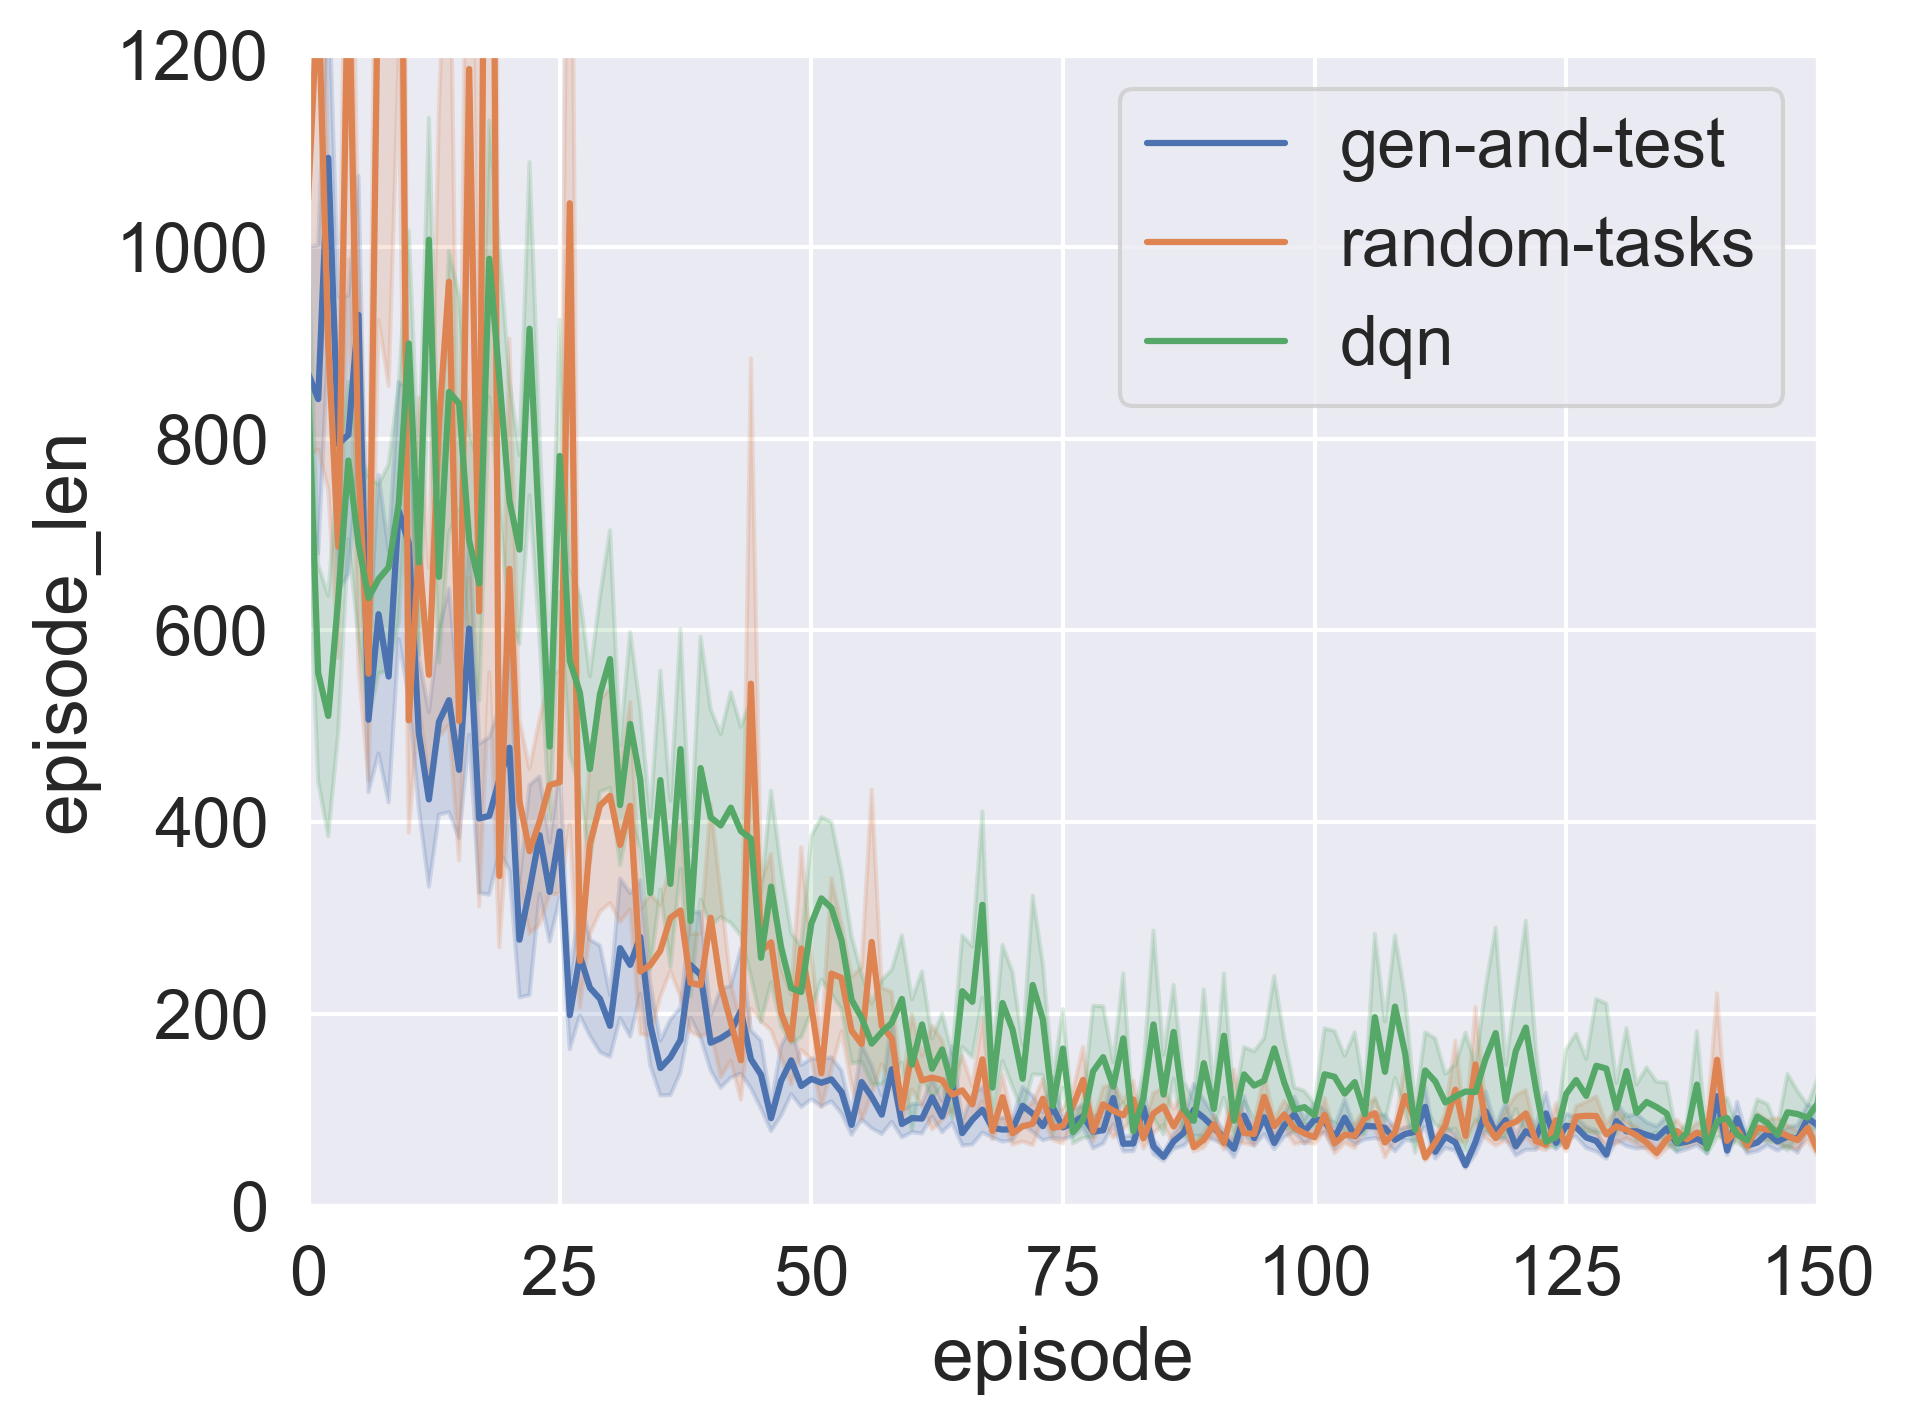

In [70]:
make_plot(SWEEP_IDS, CONDITION, X, Y, X_LIM, Y_LIM, SMOOTH, ERROR_BAR)